(data-and-models)=

# Data & models

In [1]:
import exoplanet

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


exoplanet.__version__ = '0.6.0'


This tutorial provides an overview of the kinds of datasets that `exoplanet` has been designed to model.
It's worth noting that this is certainly not a comprehensive list and `exoplanet` is designed to be _low-level_ library that can be built on top of to support new use cases.

:::{tip}
For real world use cases and examples, check out the [Case Studies](https://gallery.exoplanet.codes) page.
:::

## Overview

One primary interface to `exoplanet` is via the {class}`exoplanet.orbits.KeplerianOrbit` object (and its generalizations like {class}`exoplanet.orbits.TTVOrbit`).
The `KeplerianOrbit` object defines a set of independent (but possibly massive) bodies orbiting a central body on Keplerian trajectories.
These orbits are parameterized by orbital elements, and one of the primary uses of `exoplanet` is the measurement of these orbital elements given observations.

Given a `KeplerianOrbit`, users of `exoplanet` can evaluate things like the positions and velocities of all the bodies as a function of time.
For example, here's how you could define an orbit with a single body and plot the orbits:

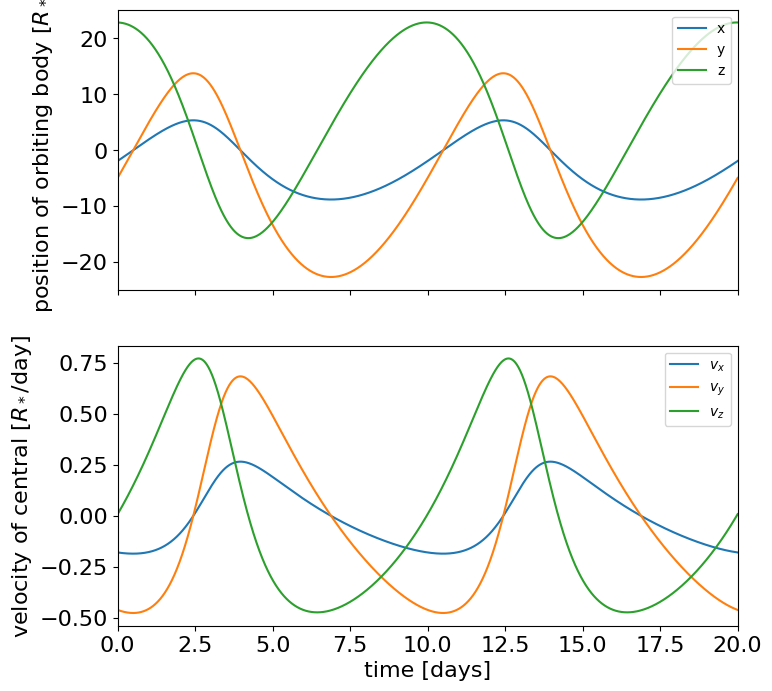

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo

# Define the orbit
orbit = xo.orbits.KeplerianOrbit(
    period=10.0,  # All times are in days
    t0=0.5,
    incl=0.5 * np.pi,  # All angles are in radians
    ecc=0.3,
    omega=-2.5,
    Omega=1.2,
    m_planet=0.05,  # All masses and distances are in Solar units
)

# Get the position and velocity as a function of time
t = np.linspace(0, 20, 5000)
x, y, z = orbit.get_relative_position(t)
vx, vy, vz = orbit.get_star_velocity(t)

# Plot the coordinates
# Note the use of `.eval()` throughout since the coordinates are all
# PyTensor objects
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
ax = axes[0]
ax.plot(t, x.eval(), label="x")
ax.plot(t, y.eval(), label="y")
ax.plot(t, z.eval(), label="z")
ax.set_ylabel("position of orbiting body [$R_*$]")
ax.legend(fontsize=10, loc=1)

ax = axes[1]
ax.plot(t, vx.eval(), label="$v_x$")
ax.plot(t, vy.eval(), label="$v_y$")
ax.plot(t, vz.eval(), label="$v_z$")
ax.set_xlim(t.min(), t.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("velocity of central [$R_*$/day]")
_ = ax.legend(fontsize=10, loc=1)

The key feature of `exoplanet` is that all of the parameters to a `KeplerianOrbit` can be `PyMC` variables.
This means that these elements are now something that you can _infer_.
For example, if we want to fit for the orbital period, we can define a `PyMC` model like the following:

In [3]:
import pymc as pm

with pm.Model():
    log_period = pm.Normal("log_period", mu=np.log(10), sigma=2.0)
    orbit = xo.orbits.KeplerianOrbit(
        period=pm.math.exp(log_period),  # ...
    )

    # Define the rest of you model using `orbit`...

In the following sections, we will go through some of the specific ways that you might use this `orbit` to define a model, but first some orbital conventions!

## Orbital conventions

These orbits are specified with respect to a single central body (generally the most massive body) and then a system of non-interacting bodies orbiting the central.
This is a good parameterization for exoplanetary systems and binary stars, but it is sometimes not sufficient for systems with multiple massive bodies where the interactions will be important to the dynamics.

We follow a set of internally consistent orbital conventions that also attempts to respect as many of the established conventions of the stellar and exoplanetary fields as possible.
The location of a body on a Keplerian orbit with respect to the center of mass is given in the perifocal plane by

$$
\boldsymbol{r} =
  \left [
    \begin{array}{c}
      x\\
      y\\
      z\\
    \end{array}
  \right ].
$$

By construction, the orbit of the body in the perifocal frame is constrained entirely to the $x -y$ plane as shown by this figure:

![Orbital geometry](../_static/orbit3D.png)

The range of orbital convention choices mainly stems from how the location of the body in the perifocal frame is converted to the observer frame,

$$
\boldsymbol{R} =
  \left [
    \begin{array}{c}
      X\\
      Y\\
      Z\\
    \end{array}
  \right ].
$$

We choose to orient the $\hat{\boldsymbol{X}}$ unit vector in the north direction, $\hat{\boldsymbol{Y}}$ in the east direction, and $\hat{\boldsymbol{Z}}$ towards the observer. Under this convention, the inclination of an orbit is defined by the dot-product of the orbital angular momentum vector with $\hat{\boldsymbol{Z}}$, conforming to the common astrometric convention that a zero inclination ($i = 0$) orbit is face-on, with the test body orbiting in a counter-clockwise manner around the primary body.

In the stellar and exoplanetary fields, there is less agreement on which segment of the line of nodes is defined as the _ascending_ node.
We choose to define the ascending node as the point where the orbiting body crosses the plane of the sky moving _away_ from the observer (i.e., crossing from $Z > 0$ to $Z< 0$).
This convention has historically been the choice of the visual binary field; the opposite convention occasionally appears in exoplanet and planetary studies.

To implement the transformation from perifocal frame to observer frame, we consider the rotation matrices

$$
  \boldsymbol{P}_x(\phi) = \left [
  \begin{array}{ccc}
    1 & 0 & 0 \\
    0 & \cos \phi & - \sin \phi \\
    0 & \sin \phi & \cos \phi \\
    \end{array}\right]
$$

$$
  \boldsymbol{P}_z (\phi) = \left [
  \begin{array}{ccc}
    \cos \phi & - \sin \phi & 0\\
    \sin \phi & \cos \phi & 0 \\
    0 & 0 & 1 \\
    \end{array}\right].
$$

which result in a _clockwise_ rotation of the axes, as defined using the right hand rule.

This means when we look down the $z$-axis, for a positive angle $\phi$, it would be as if the $x$ and $y$ axes rotated clockwise.
In order to find out what defines counter-clockwise when considering the other rotations, we look to the right hand rule and cross products of the axes unit vectors.
Since $\hat{\boldsymbol{x}} \times \hat{\boldsymbol{y}} = \hat{\boldsymbol{z}}$, when looking down the $z$ axis the direction of the $x$-axis towards the $y$-axis defines counter clockwise.
Similarly, we have $\hat{\boldsymbol{y}} \times \hat{\boldsymbol{z}} = \hat{\boldsymbol{x}}$, and $\hat{\boldsymbol{z}} \times \hat{\boldsymbol{x}} = \hat{\boldsymbol{y}}$.

To convert a position $\boldsymbol{r}$ in the perifocal frame to the observer frame $\boldsymbol{R}$ (referencing the figure above), three rotations are required:
(i) a rotation about the $z$-axis through an angle $\omega$ so that the $x$-axis coincides with the line of nodes at the ascending node,
(ii) a rotation about the $x$-axis through an angle ($-i$) so that the two planes are coincident, and finally
(iii) a rotation about the $z$-axis through an angle $\Omega$. Applying these rotation matrices yields

$$
  \boldsymbol{R} =
  \boldsymbol{P}_z (\Omega) \boldsymbol{P}_x(-i) \boldsymbol{P}_z(\omega)
  \boldsymbol{r}.
$$

As a function of true anomaly $f$, the position in the observer frame is given by

$$
  \begin{array}{lc}
    X =& r [ \cos \Omega (\cos \omega \cos f - \sin \omega \sin f)  - \sin \Omega  \cos i (\sin \omega \cos f + \cos \omega \sin f) ] \\
    Y =& r [ \sin \Omega (\cos \omega \cos f - \sin \omega \sin f) + \cos \Omega \cos i(\sin \omega \cos f + \cos \omega \sin f) ] \\
    Z =& - r \sin i (\sin \omega \cos f + \cos \omega \sin f).\\
\end{array}
$$

Simplifying the equations using the sum angle identities, we find

$$
  \begin{array}{lc}
    X =& r (\cos \Omega \cos(\omega + f) - \sin(\Omega) \sin(\omega + f) \cos(i)) \\
    Y =& r (\sin \Omega \cos(\omega + f) + \cos(\Omega) \sin(\omega + f) \cos(i)) \\
    Z =& - r \sin(\omega + f) \sin(i).\\
\end{array}
$$

The central body is defined by any two of radius $R_\star$, mass $M_\star$, or density $\rho_\star$.
The third physical parameter can always be computed using the other two so `exoplanet` will throw an error if three are given (even if they are numerically self-consistent).

The orbits are then typically defined by (check out the docstring {class}`exoplanet.orbits.KeplerianOrbit` for all the options):

- the period $P$ or semi-major axis $a$ of the orbit,
- the time of conjunction $t_0$ or time of periastron passage $t_\mathrm{p}$,
- the planet's radius $R_\mathrm{pl}$ and mass $M_\mathrm{pl}$,
- the eccentricity $e$, argument of periastron $\omega$ and the longitude of ascending node $\Omega$, and
- the inclination of the orbital plane $i$ or the impact parameter $b$.

A `KeplerianOrbit` object in `exoplanet` will always be fully specified.
For example, if the orbit is defined using the period $P$, the semi-major axis $a$ will be computed using Kepler's third law.

(data-and-models/rvs)=

## Radial velocities

A {class}`exoplanet.orbits.KeplerianOrbit` can be used to compute the expected radial velocity time series for a given set of parameters.
One typical parameterization for a radial velocity fit would look something like this:

/home/docs/checkouts/readthedocs.org/user_builds/exoplanet/envs/latest/lib/python3.10/site-packages/rich/live.py:23
1: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/docs/checkouts/readthedocs.org/user_builds/exoplanet/envs/latest/lib/python3.10/site-packages/rich/live.py:23
1: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Auto-assigning NUTS sampler...


Initializing NUTS using adapt_full...


/home/docs/checkouts/readthedocs.org/user_builds/exoplanet/envs/latest/lib/python3.10/site-packages/pymc/step_methods/hmc/quadpotential.py:627: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [log_period, log_semiamp, ecc, __plus_angle1, __plus_angle2, __minus_angle1, __minus_angle2, log_jitter, zero_point]


/home/docs/checkouts/readthedocs.org/user_builds/exoplanet/envs/latest/lib/python3.10/site-packages/rich/live.py:23
1: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 38 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
ecc          0.052  0.029   0.000    0.099      0.001    0.001    1031.0   
log_jitter  -2.901  5.181 -12.316    7.300      0.106    0.119    2458.0   
log_period   2.302  0.004   2.294    2.309      0.000    0.000    2016.0   
log_semiamp  1.627  0.034   1.557    1.689      0.001    0.001    1823.0   
minus        0.808  0.035   0.745    0.872      0.001    0.001    2155.0   
omega       -1.803  1.082  -3.729   -0.037      0.039    0.027     853.0   
period       9.992  0.038   9.919   10.064      0.001    0.001    2016.0   
phi         -0.187  1.090  -2.084    1.654      0.039    0.032     859.0   
plus        -0.995  1.086  -3.004    0.709      0.039    0.028     854.0   
semiamp      5.089  0.173   4.747    5.415      0.004    0.003    1823.0   
tperi       -0.298  1.735  -3.300    2.636      0.062    0.050     858.0   
zero_point  -0.124  0.115  -0.339    0.089      0.002    0.002    2280.0   

             ess_tail  r_hat  
ecc             914.0    1.0  
log_jitter     1211.0    1.0  
log_period     1389.0    1.0  
log_semiamp    1287.0    1.0  
minus          1520.0    1.0  
omega           609.0    1.0  
period         1389.0    1.0  
phi             601.0    1.0  
plus            609.0    1.0  
semiamp        1287.0    1.0  
tperi           609.0    1.0  
zero_point     1498.0    1.0

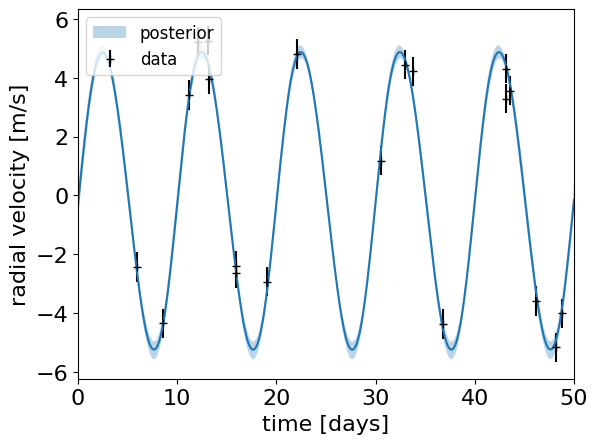

In [4]:
import arviz as az
import pymc_ext as pmx
import pytensor.tensor as pt

# Create a dummy dataset
random = np.random.default_rng(1234)
t_plot = np.linspace(0, 50, 500)
t = np.sort(random.uniform(0, 50, 20))
rv_err = 0.5 + np.zeros_like(t)
rv_obs = 5.0 * np.sin(2 * np.pi * t / 10.0) + np.sqrt(
    0.05**2 + rv_err**2
) * random.normal(size=len(t))

with pm.Model():
    # Period, semi-amplitude, and eccentricity
    log_period = pm.Normal("log_period", mu=np.log(10.0), sigma=1.0)
    period = pm.Deterministic("period", pt.exp(log_period))
    log_semiamp = pm.Normal("log_semiamp", mu=np.log(5.0), sigma=2.0)
    semiamp = pm.Deterministic("semiamp", pt.exp(log_semiamp))
    ecc = pm.Uniform("ecc", lower=0, upper=0.5, initval=0.01)

    # At low eccentricity, omega and the phase of periastron (phi) are
    # correlated so it can be best to fit in (omega ± phi) / 2
    plus = pmx.angle("plus")
    minus = pmx.angle("minus")
    phi = pm.Deterministic("phi", plus + minus)
    omega = pm.Deterministic("omega", plus - minus)

    # For non-zero eccentricity, it can sometimes be better to use
    # sqrt(e)*sin(omega) and sqrt(e)*cos(omega) as your parameters:
    #
    #     h, k = xo.unit_disk("h", "k")
    #     ecc = pm.Deterministic("ecc", h**2 + k**2)
    #     omega = pm.Deterministic("omega", pt.arctan2(h, k))
    #     phi = xo.angle("phi")

    # Jitter & the system mean velocity offset
    log_jitter = pm.Normal("log_jitter", mu=np.log(0.05), sigma=5.0)
    zero_point = pm.Normal("zero_point", mu=0, sigma=10.0)

    # Then we define the orbit
    tperi = pm.Deterministic("tperi", period * phi / (2 * np.pi))
    orbit = xo.orbits.KeplerianOrbit(
        period=period, t_periastron=tperi, ecc=ecc, omega=omega
    )

    # And define the RV model
    rv_model = zero_point + orbit.get_radial_velocity(t, K=semiamp)

    # Finally add in the observation model
    err = pt.sqrt(rv_err**2 + pt.exp(2 * log_jitter))
    pm.Normal("obs", mu=rv_model, sigma=rv_err, observed=rv_obs)

    # We'll also track the model just for plotting purposes
    pm.Deterministic(
        "__rv_plot", zero_point + orbit.get_radial_velocity(t_plot, K=semiamp)
    )

    soln = pmx.optimize(vars=[plus, minus])
    soln = pmx.optimize(soln)
    trace = pm.sample(
        tune=1000,
        draws=1000,
        cores=2,
        chains=2,
        initvals=soln,
        target_accept=0.9,
        init="adapt_full",
    )

# Plot the results
rv_plot = trace.posterior["__rv_plot"].values
q16, q50, q84 = np.percentile(rv_plot, [16, 50, 84], axis=(0, 1))
plt.errorbar(t, rv_obs, yerr=rv_err, fmt="+k", label="data")
plt.plot(t_plot, q50)
plt.fill_between(t_plot, q16, q84, alpha=0.3, label="posterior")
plt.xlim(0, 50)
plt.legend(fontsize=12, loc=2)
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")

az.summary(trace, var_names=["^(?!__).*"], filter_vars="regex")

Instead of using `semiamp` as a parameter, we could have passed `m_planet` and `incl` as parameters to `KeplerianOrbit` and fit the physical orbit.
Similarly, if we we doing a joint fit with a transit light curve (see {ref}`data-and-models/combining` below) we could have parameterized in terms of `t0` (the time of a reference transit) instead of the phase of periastron.

As mentioned in the comments above and discussed in {ref}`reparameterization`, the performance of these fits can be problem specific and depend on the choice of parameters.
Therefore it is often worthwhile experimenting with different parameterizations, but this can be a good place to start for radial velocity-only fits.

(data-and-models/astrometry)=

## Astrometry

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time, but `exoplanet` could also be used to model the motion of the center of light for and unresolved orbit.
The typical {class}`exoplanet.orbits.KeplerianOrbit` definition for and astrometric dataset will be similar to a radial velocity fit:

Auto-assigning NUTS sampler...


Initializing NUTS using adapt_full...


/home/docs/checkouts/readthedocs.org/user_builds/exoplanet/envs/latest/lib/python3.10/site-packages/pymc/step_methods/hmc/quadpotential.py:627: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [log_period, log_a, ecc, tperi, __plus_angle1, __plus_angle2, __minus_angle1, __minus_angle2, cos_incl]


/home/docs/checkouts/readthedocs.org/user_builds/exoplanet/envs/latest/lib/python3.10/site-packages/rich/live.py:23
1: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 38 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


mean        sd    hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
Omega          -0.002     0.021    -0.039      0.039      0.000    0.000   
a               0.321     0.022     0.282      0.360      0.001    0.000   
cos_incl        0.298     0.017     0.263      0.329      0.001    0.000   
ecc             0.527     0.037     0.461      0.595      0.001    0.001   
incl            1.268     0.018     1.235      1.304      0.001    0.000   
log_a          -1.137     0.067    -1.262     -1.018      0.002    0.001   
log_period      9.222     0.110     9.053      9.451      0.004    0.003   
minus          -0.022     0.029    -0.078      0.031      0.001    0.001   
omega           0.042     0.042    -0.036      0.123      0.001    0.001   
period      10179.053  1165.168  8302.620  12388.895     39.414   28.989   
plus            0.020     0.016    -0.011      0.049      0.000    0.000   
tperi        3548.796    35.755  3479.392   3613.493      0.895    0.633   

            ess_bulk  ess_tail  r_hat  
Omega         2057.0    1585.0   1.01  
a             1182.0    1440.0   1.00  
cos_incl      1204.0    1226.0   1.00  
ecc           1000.0     972.0   1.00  
incl          1204.0    1226.0   1.00  
log_a         1182.0    1440.0   1.00  
log_period    1054.0     952.0   1.00  
minus         1806.0    1381.0   1.00  
omega         1702.0    1460.0   1.00  
period        1054.0     952.0   1.00  
plus          1641.0    1408.0   1.00  
tperi         1593.0    1428.0   1.00

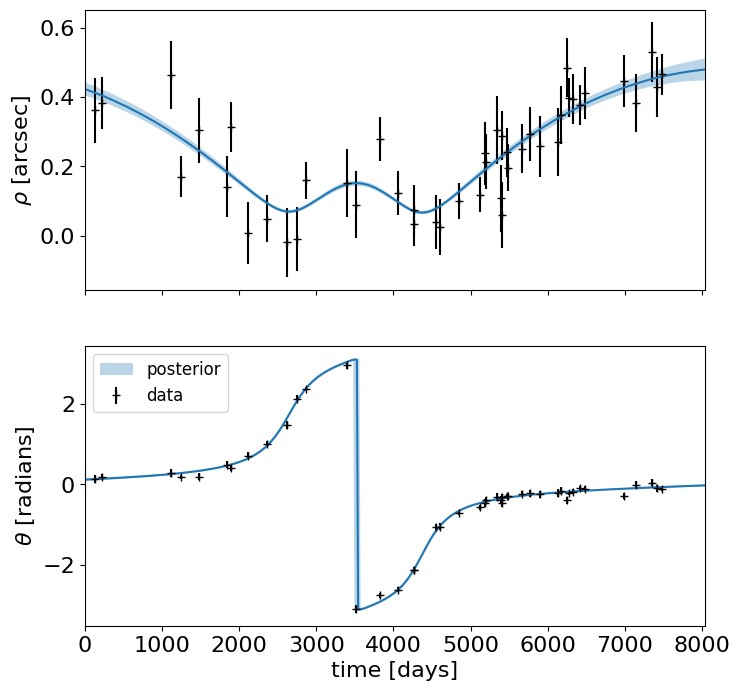

In [5]:
random = np.random.default_rng(5678)
t_plot = np.linspace(0, 22 * 365.25, 500)
t = np.sort(random.uniform(0.0, 22 * 365.25, 45))
rho_err = random.uniform(0.05, 0.1, len(t))
theta_err = random.uniform(0.05, 0.1, len(t))

with pm.Model():
    # Period, semi-major axis, eccentricity, and t0
    log_period = pm.Normal("log_period", mu=np.log(25.0 * 365.25), sigma=1.0)
    period = pm.Deterministic("period", pt.exp(log_period))
    log_a = pm.Normal("log_a", mu=np.log(0.3), sigma=2.0)
    a = pm.Deterministic("a", pt.exp(log_a))
    ecc = pm.Uniform("ecc", lower=0, upper=1)
    tperi = pm.Normal("tperi", mu=3500.0, sigma=1000.0)

    # For astrometric orbits, a good choice of parameterization can be
    # (Omega ± omega) / 2
    plus = pmx.angle("plus")
    minus = pmx.angle("minus")
    Omega = pm.Deterministic("Omega", plus + minus)
    omega = pm.Deterministic("omega", plus - minus)

    # We'll use a uniform prior on cos(incl)
    cos_incl = pm.Uniform("cos_incl", lower=-1.0, upper=1.0, initval=0.3)
    incl = pm.Deterministic("incl", pt.arccos(cos_incl))

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(
        a=a,
        t_periastron=tperi,
        period=period,
        incl=incl,
        ecc=ecc,
        omega=omega,
        Omega=Omega,
    )

    # And define the RV model
    rho_model, theta_model = orbit.get_relative_angles(t)

    # ================================================== #
    # Simulate data from the model for testing           #
    # You should remove the following lines in your code #
    # ================================================== #
    rho_obs, theta_obs = pmx.eval_in_model([rho_model, theta_model])
    rho_obs += rho_err * random.normal(size=len(t))
    theta_obs += theta_err * random.normal(size=len(t))
    # =============== end simulated data =============== #

    # Define the observation model this is simple for rho:
    pm.Normal("rho_obs", mu=rho_model, sigma=rho_err, observed=rho_obs)

    # But we want to be cognizant of the fact that theta wraps so the following
    # is equivalent to
    #
    #   pm.Normal("obs_theta", mu=theta_model, observed=theta_obs, sigma=theta_err)
    #
    # but takes into account the wrapping
    theta_diff = pt.arctan2(
        pt.sin(theta_model - theta_obs), pt.cos(theta_model - theta_obs)
    )
    pm.Normal(
        "theta_obs",
        mu=theta_diff,
        sigma=theta_err,
        observed=np.zeros_like(theta_obs),
    )

    # We'll also track the model just for plotting purposes
    rho_plot, theta_plot = orbit.get_relative_angles(t_plot)
    pm.Deterministic("__rho_plot", rho_plot)
    pm.Deterministic("__theta_plot", theta_plot)

    trace = pm.sample(
        tune=1000,
        draws=1000,
        cores=2,
        chains=2,
        target_accept=0.95,
        init="adapt_full",
    )

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

q16, q50, q84 = np.percentile(
    trace.posterior["__rho_plot"].values, [16, 50, 84], axis=(0, 1)
)
ax1.errorbar(t, rho_obs, yerr=rho_err, fmt="+k", label="data")
ax1.plot(t_plot, q50)
ax1.fill_between(t_plot, q16, q84, alpha=0.3, label="posterior")
ax1.set_ylabel(r"$\rho$ [arcsec]")

q16, q50, q84 = np.percentile(
    trace.posterior["__theta_plot"].values, [16, 50, 84], axis=(0, 1)
)
ax2.errorbar(t, theta_obs, yerr=rho_err, fmt="+k", label="data")
ax2.plot(t_plot, q50)
ax2.fill_between(t_plot, q16, q84, alpha=0.3, label="posterior")
ax2.set_xlim(t_plot.min(), t_plot.max())
ax2.legend(fontsize=12, loc=2)
ax2.set_ylabel(r"$\theta$ [radians]")
ax2.set_xlabel("time [days]")

# Compute the convergence stats
az.summary(trace, var_names=["^(?!__).*"], filter_vars="regex")

In this example, the units of `a` are arcseconds, but the {func}`exoplanet.orbits.KeplerianOrbit.get_relative_angles` function accepts a parallax argument if you have a constraint on the parallax of the system.
If you provide parallax as an argument, `a` should be provided in the usual units of Solar radii.

(data-and-models/transits)=

## Transits, occultations, and eclipses

`exoplanet` has built in support for evaluating quadratically limb darkened light curve models using the algorithm from [Agol et al. (2020)](https://arxiv.org/abs/1908.03222).
If you need flexible surface models or higher order limb darkening, check out the [`starry` package](https://starry.readthedocs.io) which also integrates with `PyMC` (3, but not 5 at the time of writing this).

Transit and occultation modeling is one of the primary applications of `exoplanet` so there are quite a few options (including transit timing variations, detached eclipsing binary modeling, and much more) that are highlighted on the [Case Studies](https://gallery.exoplanet.codes) page.
But, a bread-and-butter transit model implemented in `exoplanet` might look something like the following:

Auto-assigning NUTS sampler...


Initializing NUTS using adapt_full...


/home/docs/checkouts/readthedocs.org/user_builds/exoplanet/envs/latest/lib/python3.10/site-packages/pymc/step_methods/hmc/quadpotential.py:627: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [mean, t0, t1, __u_q1, __u_q2, log_r, __b_impact_parameter]


/home/docs/checkouts/readthedocs.org/user_builds/exoplanet/envs/latest/lib/python3.10/site-packages/rich/live.py:23
1: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 56 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b        0.330  0.122   0.085    0.513      0.006    0.004     452.0   
log_r   -3.228  0.044  -3.310   -3.150      0.002    0.001     566.0   
mean     0.000  0.000  -0.000    0.000      0.000    0.000    1136.0   
period   7.212  0.001   7.210    7.215      0.000    0.000    1119.0   
r        0.040  0.002   0.037    0.043      0.000    0.000     566.0   
t0       4.350  0.003   4.344    4.357      0.000    0.000    1047.0   
t1      33.200  0.003  33.194   33.206      0.000    0.000     976.0   
u[0]     0.545  0.349   0.000    1.142      0.013    0.009     729.0   
u[1]     0.104  0.360  -0.512    0.773      0.011    0.008    1138.0   

        ess_tail  r_hat  
b          575.0   1.00  
log_r      985.0   1.00  
mean      1059.0   1.00  
period    1106.0   1.00  
r          985.0   1.00  
t0         825.0   1.00  
t1         857.0   1.01  
u[0]       791.0   1.00  
u[1]      1115.0   1.00

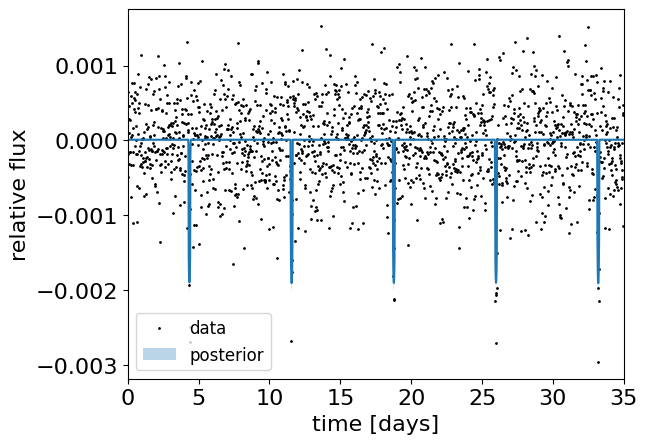

In [6]:
random = np.random.default_rng(123)
num_transits = 4
t = np.arange(0, 35, 0.02)
yerr = 5e-4

with pm.Model():
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sigma=1.0)

    # Often the best parameterization is actually in terms of the
    # times of two reference transits rather than t0 and period
    t0 = pm.Normal("t0", mu=4.35, sigma=1.0)
    t1 = pm.Normal("t1", mu=33.2, sigma=1.0)
    period = pm.Deterministic("period", (t1 - t0) / num_transits)

    # The Kipping (2013) parameterization for quadratic limb darkening
    # paramters
    u = xo.distributions.quad_limb_dark("u", initval=np.array([0.3, 0.2]))

    # The radius ratio and impact parameter; these parameters can
    # introduce pretty serious covariances and are ripe for
    # reparameterization
    log_r = pm.Normal("log_r", mu=np.log(0.04), sigma=2.0)
    r = pm.Deterministic("r", pt.exp(log_r))
    b = xo.distributions.impact_parameter("b", r, initval=0.35)

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve; note that we index using `[:, 0]`
    # since `get_light_curve` returns an object with the shape
    # `(n_times, n_planets)`
    light_curve = (
        xo.LimbDarkLightCurve(u[0], u[1]).get_light_curve(
            orbit=orbit, r=r, t=t
        )[:, 0]
        + mean
    )

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("__light_curve", light_curve)

    # ================================================== #
    # Simulate data from the model for testing           #
    # You should remove the following lines in your code #
    # ================================================== #
    y = pmx.eval_in_model(light_curve)
    y += yerr * random.normal(size=len(y))
    # =============== end simulated data =============== #

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sigma=yerr, observed=y)

    trace = pm.sample(
        tune=1000, draws=1000, cores=2, chains=2, init="adapt_full"
    )

# Plot the results
q16, q50, q84 = np.percentile(
    trace.posterior["__light_curve"].values, [16, 50, 84], axis=(0, 1)
)
plt.plot(t, y, ".k", ms=2, label="data")
plt.plot(t, q50)
plt.fill_between(t, q16, q84, alpha=0.3, label="posterior")
plt.xlim(0.0, 35)
plt.legend(fontsize=12, loc=3)
plt.xlabel("time [days]")
plt.ylabel("relative flux")

# Compute the convergence stats
az.summary(trace, var_names=["^(?!__).*"], filter_vars="regex")

(data-and-models/combining)=

## Combining datasets

Since `exoplanet` is built on top of `PyMC`, it has the capacity to support essentially arbitrarily complicated models.
This means that you can share parameters or fit multiple datasets however you want.
We won't go into too many details about this here, but you can see some examples on the [Case Studies](https://gallery.exoplanet.codes) of joint transit/radial velocity fits, or inferences based on datasets from multiple instruments.

The basic idea behind how to simultaneously fit multiple datasets is that you'll need to define the relationship between the datasets (perhaps share parameters or a shared `KeplerianOrbit`) and then you'll include the likelihood for each dataset in your model.
In all of the above examples, we had a line like

```python
pm.Normal("obs", mu=rv_model, sigma=rv_err, observed=rv_obs)
```

in all of our models.
This defines a Gaussian likelihood conditioned on the `observed` data.
To combine datasets, you can simply add multiple lines like this (one for each dataset) and, behind the scenes, `PyMC` will multiply these likelihoods (or actually add their logarithms) as it should.

For more concrete examples, check out the [Case Studies](https://gallery.exoplanet.codes) and (if that's not sufficient) feel free to start [a "discussion" on the GitHub repository](https://github.com/exoplanet-dev/exoplanet/discussions) asking for help.